## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import holidays

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

## Import data

In [2]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

train_data.date = pd.to_datetime(train_data.date)
test_data['date'] = pd.to_datetime(test_data['date'])

## Data Preparation

In [3]:
# Create columns for day of week

def get_week_day(d):
    return int(datetime.strftime(d, "%w"))+1

train_data['week_day'] = train_data['date'].apply(get_week_day)
test_data['week_day'] = test_data['date'].apply(get_week_day)

In [4]:
# Extract the year and month values from date

train_data['year'] = train_data['date'].apply(lambda d: int(datetime.strftime(d, "%Y")))
train_data['month'] = train_data['date'].apply(lambda d: int(datetime.strftime(d, "%m")))

test_data['year'] = test_data['date'].apply(lambda d: int(datetime.strftime(d, "%Y")))
test_data['month'] = test_data['date'].apply(lambda d: int(datetime.strftime(d, "%m")))

In [5]:
# Create column for weekend - boolean

def if_weekend(col):
    if col == 1 or col == 7:
        return 1

    return 0

train_data['is_weekend'] = train_data.loc[:, 'week_day'].apply(if_weekend)
test_data['is_weekend'] = test_data.loc[:, 'week_day'].apply(if_weekend)

In [6]:
# get the list of holidays for all countries in all years

years = np.concatenate((train_data['year'].unique(), test_data['year'].unique()), axis=None).tolist()
countries = train_data['country'].unique().tolist()

def get_holiday_list(country, year):
    list_name = f'{country}_holidays'
    holiday_list = holidays.country_holidays(country, years=year, language='en_US')
    train_data[list_name] = train_data.loc[train_data['country'] == country, 'date'].apply(
        lambda x: x in holiday_list
    )
    test_data[list_name] = test_data.loc[test_data['country'] == country, 'date'].apply(
        lambda x: x in holiday_list
    )

for i in countries:
    get_holiday_list(i, years)

In [7]:
# Create a boolean column indicating whether the date for a country was a holiday

train_data['is_holiday'] = train_data.iloc[:, -5:].sum(axis=1).astype('int')
test_data['is_holiday'] = test_data.iloc[:, -5:].sum(axis=1).astype('int')

In [8]:
# Drop the individual country's holiday list

train_data = train_data.drop(['Argentina_holidays', 'Canada_holidays', 'Estonia_holidays',
                             'Japan_holidays', 'Spain_holidays'], axis=1)
test_data = test_data.drop(['Argentina_holidays', 'Canada_holidays', 'Estonia_holidays',
                             'Japan_holidays', 'Spain_holidays'], axis=1)

In [26]:
train_data.head()

,id,date,country,store,product,num_sold,week_day,year,month,is_weekend,is_holiday
0,0,2017-01-01,0,1,0,63,1,2017,1,1,1
1,1,2017-01-01,0,1,1,66,1,2017,1,1,1
2,2,2017-01-01,0,1,2,9,1,2017,1,1,1
3,3,2017-01-01,0,1,3,59,1,2017,1,1,1
4,4,2017-01-01,0,1,4,49,1,2017,1,1,1


In [27]:
test_data.head()

,id,date,country,store,product,week_day,year,month,is_weekend,is_holiday
0,136950,2022-01-01,0,1,0,7,2022,1,1,1
1,136951,2022-01-01,0,1,1,7,2022,1,1,1
2,136952,2022-01-01,0,1,2,7,2022,1,1,1
3,136953,2022-01-01,0,1,3,7,2022,1,1,1
4,136954,2022-01-01,0,1,4,7,2022,1,1,1


In [9]:
# Label encode text columns

encoder = LabelEncoder()

text_cols = ['country', 'store', 'product']

for var in text_cols:
    train_data[var] = encoder.fit_transform(train_data.loc[:, var])
    test_data[var] = encoder.fit_transform(test_data.loc[:, var])

## EDA

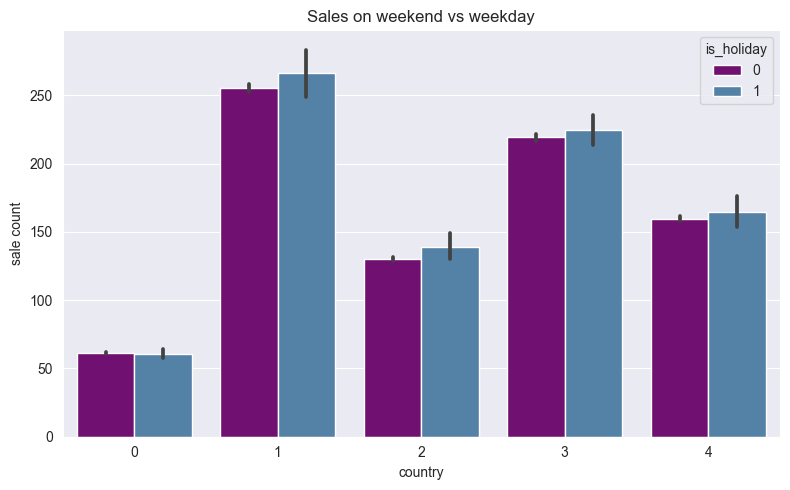

In [20]:
# Does the holiday have an impact on sales?

plt.figure(figsize=(8, 5))

sns.barplot(data=train_data,
             x='country',
             y='num_sold',
             hue='is_holiday',
            palette=['purple', 'steelblue'])
plt.title("Sales on weekend vs weekday")
plt.ylabel("sale count")

plt.tight_layout()
plt.show()

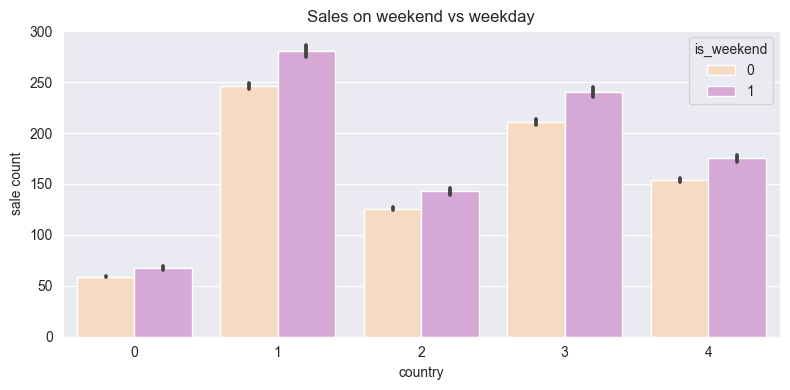

In [22]:
# Does the weekend have an impact on sales?

plt.figure(figsize=(8, 4))

sns.barplot(data=train_data,
             x='country',
             y='num_sold',
             hue='is_weekend',
            palette=['peachpuff', 'plum'])
plt.title("Sales on weekend vs weekday")
plt.ylabel("sale count")

plt.tight_layout()
plt.show()

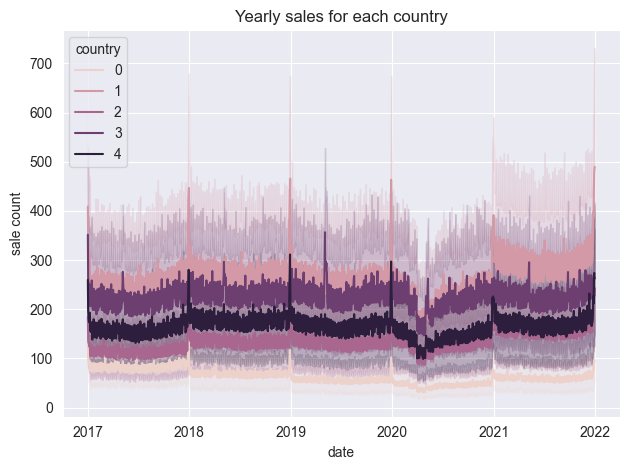

In [23]:
# Number of products sold everyday country wise

sns.lineplot(data=train_data, x="date", y="num_sold", hue="country")
plt.title("Yearly sales for each country")
plt.ylabel("sale count")

plt.tight_layout()
plt.show()

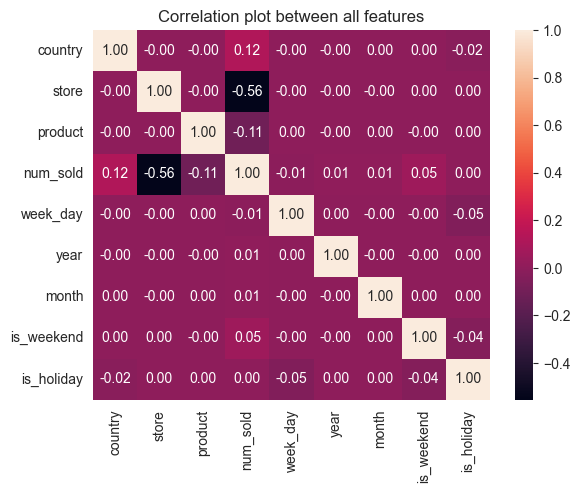

In [24]:
# Determine if there is any multi-collinearity

sns.heatmap(train_data.iloc[:, 2:].corr(), annot=True, fmt=".2f")
plt.title("Correlation plot between all features")

plt.show()

## Model Training

In [14]:
# Split the data into predictors and response variable

predictors = ['country', 'store', 'product', 'week_day', 'year', 'month', 'is_weekend', 'is_holiday']

X = train_data.loc[:, predictors]
y = train_data.loc[:, 'num_sold']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [15]:
# Fit the RandomForest regressor

reg_model = RandomForestRegressor(n_estimators=20, criterion='absolute_error', max_samples=5500)

reg_model.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_samples=5500,
                      n_estimators=20)

In [16]:
# Predict using the built model

y_pred = reg_model.predict(X_test)

pred_df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

11.045443592552028


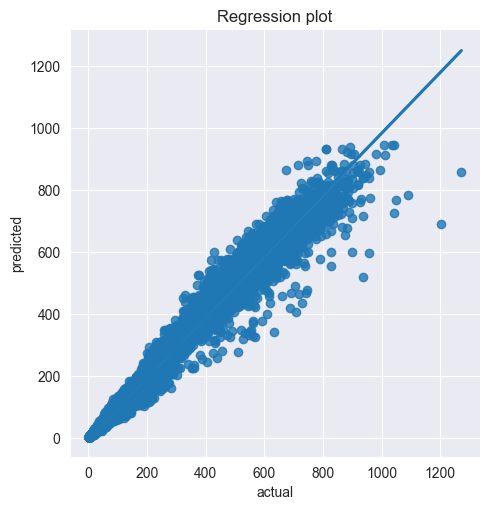

In [25]:
# Plot the results and error score

print(mean_absolute_error(y_test, y_pred))

sns.lmplot(data=pred_df, x='actual', y='predicted')
plt.title("Regression plot")

plt.show()